In [71]:
import numpy as np
from utils import Environment, GameDifficulty, Experiment
from policy import E_Greedy
import matplotlib.pyplot as plt
import os, pickle

In [72]:
# Simple train loop

def train(episode, env, lr, gamma, policy):
    reward_history = []
    for episode in range(episode):
        while not env.is_gameover:
            # choose action
            idx_action = policy.take_action(env.agent.current_location, env.q_values)
            # store previous coordinates of the agent
            prev_x, prev_y = env.agent.current_location
            # transition to next state and get immediate reward
            reward = env.step(idx_action)
            # get previous q-value
            prev_q_value = env.q_values[prev_x, prev_y, idx_action]
            # store updated agent location
            agent_x, agent_y = env.agent.current_location
            # compute temporal error difference
            t_d_error = reward + (gamma * np.max(env.q_values[agent_x, agent_y]) - prev_q_value)
            # update Q-value of the previous state-action pair.
            updated_q_value = prev_q_value + (lr * t_d_error)
            env.q_values[prev_x, prev_y, idx_action] = updated_q_value
        # average final reward over the number of action taken
        reward_history.append(env.final_reward)
        env.reset()
    return reward_history, env.q_values

In [74]:
exp_results = {}
save_path = os.path.join(os.curdir, 'saved_files/difficulty_comparison.pickle')

if os.path.exists(save_path):
    # load values
    with open(save_path, 'rb') as file2load:
        exp_results = pickle.load(file2load)

else:
    os.mkdir(os.path.join(os.curdir, 'saved_files'))
    experiments = [Experiment(difficulty=GameDifficulty.EASY),
                   Experiment(difficulty=GameDifficulty.MEDIUM),
                   Experiment(difficulty=GameDifficulty.HARD),
                   Experiment(difficulty=GameDifficulty.EXTREME)]

    for exp in experiments:
        history_rewards = []
        history_q_values = []
        dim = 60
        env = Environment(dimension=dim, difficulty=exp.difficulty)
        policy = E_Greedy(exp.epsilon)
        rewards, q_values = train(episode=exp.episodes, env=env, lr=exp.lr, gamma=exp.gamma, policy=policy)
        history_rewards.append(rewards)
        history_q_values.append(q_values)
        exp_results[exp.difficulty.name] = {'q_values': history_q_values,
                                            'rewards': history_rewards,
                                            'dim': dim}
        print('First experiment completed')
    file_name = 'difficulty_comparison.pickle'
    with open(os.path.join(os.curdir, 'saved_files/'+file_name), 'wb') as file2store:
        pickle.dump(exp_results, file2store, protocol=pickle.HIGHEST_PROTOCOL)

In [75]:
def plot_image(exp_results, exp_name):
    n_experiments = len(exp_results[exp_name]['rewards'])
    dim = exp_results[exp_name]['dim']
    plt.figure(figsize=(10, 8))
    for i in range(n_experiments):
        plt.subplot(2, 2, i+1)
        plt.plot(exp_results[exp_name]['rewards'][i])
        plt.xscale('log')
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.title('{} Results, Dimension {}'.format(exp_name, dim))

    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()

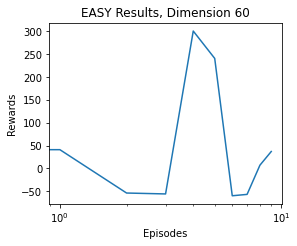

In [76]:
plot_image(exp_results, exp_name='EASY')

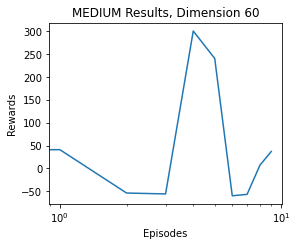

In [77]:
plot_image(exp_results, exp_name='MEDIUM')

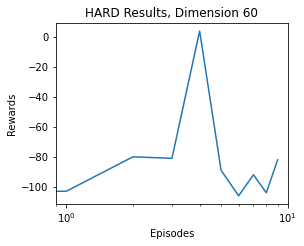

In [78]:
plot_image(exp_results, exp_name='HARD')

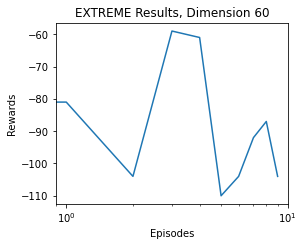

In [79]:
plot_image(exp_results, exp_name='EXTREME')

In [81]:
# Check how the reward behaves when the dimensions and the eps-values change
# Set an eps value and a dimension. Execute experiments, compute avg to see
# how different eps values affect rewards in different sizes.

# Hyperparameters
eps_values = [.01, .1, .2, .5]
dimensions = [20, 30, 40, 60]

results = {}
gamma = .9
episodes = 10
# in a stochastic environment we want the agent to learn little by little
# lr = 0 -> no learning
# lr = 1 -> learn only the most recent information
lr = .1

save_path = os.path.join(os.curdir, 'saved_files/eps_vs_dimensions.pickle')
if os.path.exists(save_path):
    # load values
    with open(save_path, 'rb') as file2load:
        results = pickle.load(file2load)
else:
    for idx, eps in enumerate(eps_values):
        reward_history = []
        q_values_history = []
        for dim in dimensions:
            name_exp = 'Experiment {}'.format(idx+1)
            policy = E_Greedy(eps)
            env = Environment(dimension=dim, difficulty=GameDifficulty.MEDIUM)
            rewards, q_values = train(episodes, env, lr=lr, gamma=gamma, policy=policy)
            reward_history.append(rewards)
            q_values_history.append(q_values)
        results[name_exp] = {'rewards': reward_history, 'q_values': q_values_history}
        print('{} done.'.format(name_exp))
    file_name = 'eps_vs_dimensions.pickle'
    with open(os.path.join(os.curdir, 'saved_files/'+file_name), 'wb') as file2store:
        pickle.dump(results, file2store, protocol=pickle.HIGHEST_PROTOCOL)

In [82]:
for exp_name in results.keys():
    exp = results[exp_name]
    rewards_history = exp['rewards']
    avg_reward = np.sum(rewards_history, axis=1) / episodes
    print(avg_reward)

[ 42.7  51.  146.5 107.3]
[ 77.8  67.5 100.5  66.3]
[ 35.8 116.9 100.1  18.3]
[-16.2  40.   34.4  28.7]
